# Manipulate  feature of each layer and observe the effect

In [1]:
import os
from typing import List, DefaultDict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# from numpy.linalg import norm
# import matplotlib
from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment


import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator
from clearn.utils.data_loader import load_images
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z,get_significant_dimensions
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
from clearn.analysis.encode_decode import decode, encode, encode_and_get_features, decode_and_get_features, decode_l3
from clearn.analysis.cluster_utils import plot_features, trace_dim
from matplotlib import pyplot  as  plt

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

# Function Definitions

In [2]:
def find_absolute_largest_weights(weights, num_out_units):
    """
    Find the maximum of absolute value weights connecting to each output unit
    @return returns an array of shape (num_out_units)
    """
    max_abs_for_each_out_dimension_weight = np.asarray([np.max(np.abs(weights[:, i])) for i in range(num_out_units)] )
    max_abs_for_each_out_dimension_weight = np.reshape(max_abs_for_each_out_dimension_weight, (num_out_units, 1))
    return max_abs_for_each_out_dimension_weight


In [3]:
def display_images(images_0):
    for i, im in enumerate(images_0):
        plt.imshow(np.squeeze(im),cmap="gray")
        plt.figure()


# Experiment Parameters

In [4]:
recompute_feature_vectors = False
significant_threshold = 0.1
LEAK = 0.2
run_id = 0
z_dim = 10
experiment_name = "un_supervised_classification_z_dim_10"
root_path="/Users/sunilv/concept_learning_exp"
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              z_dim=z_dim,
                              num_units=[64, 128, 32],
                              num_cluster_config=None,
                              confidence_decay_factor=5,
                              beta=5,
                              supervise_weight=150,
                              dataset_name="mnist",
                              split_name="Split_1",
                              model_name="VAE",
                              batch_size=64,
                              eval_interval=300,
                              name=experiment_name,
                              num_val_samples=128,
                              total_training_samples=60000,
                              manual_labels_config=TrainValDataIterator.USE_CLUSTER_CENTER,
                              reconstruction_weight=1,
                              activation_hidden_layer="RELU",
                              activation_output_layer="SIGMOID"
                              )

exp_config.check_and_create_directories(run_id)

True

# Load Trained Model

In [1]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=exp_config.BATCH_SIZE,
                                z_dim=z_dim,
                                dataset_name=exp_config.dataset_name,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        print(model.get_trainable_vars())
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        encoder_params = model.get_encoder_weights_bias()
        decoder_params =model.get_decoder_weights_bias()
        
tf.reset_default_graph()

NameError: name 'tf' is not defined

# Encoder parameters

In [6]:
encoder_keys = [k for  k in encoder_params]
print(encoder_keys)
conv1_weights = encoder_params["encoder/en_conv1/w:0"]
conv1_bias = encoder_params["encoder/en_conv1/biases:0"]
print(conv1_bias.shape)
print(conv1_weights.shape)

final_layer_weights = encoder_params["encoder/en_fc4/Matrix:0"]
final_layer_bias = encoder_params["encoder/en_fc4/bias:0"]
print(f"Final layer bias shape {final_layer_bias.shape}")
print(f"Final layer weight shape {final_layer_weights.shape}")


mean_weithts = final_layer_weights[:,0:z_dim]
mean_weithts.shape


['encoder/en_conv1/w:0', 'encoder/en_conv1/biases:0', 'encoder/en_conv2/w:0', 'encoder/en_conv2/biases:0', 'encoder/en_fc3/Matrix:0', 'encoder/en_fc3/bias:0', 'encoder/en_fc4/Matrix:0', 'encoder/en_fc4/bias:0']
(64,)
(3, 3, 1, 64)
Final layer bias shape (20,)
Final layer weight shape (32, 20)


(32, 10)

## Plot the maximum absolute value of weights connecting to each output unit of encoder final layer

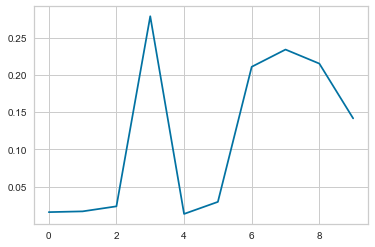

In [7]:
max_abs_for_each_lv_dimension_weight = find_absolute_largest_weights(weights=mean_weithts,
                                                                     num_out_units=mean_weithts.shape[1]
                                                                    )
plt.plot(max_abs_for_each_lv_dimension_weight)

## Get the output dimensions where weights are significant

In [8]:
def cluster_dimensions(lv_dimensions, file_name):
    """
    Find the indices with most significant values on the vector `lv_dimensions`
    @param lv_dimensions
    @param file_name full path and name of the file for saving the elbow graph
    @returns a 1-d ndarray with values as indices of most significant values in input vector
    """
    plt.figure()
    kmeans_model = KMeans()
    visualizer = KElbowVisualizer(kmeans_model, k=(1, 10))
    visualizer.fit(lv_dimensions)
    visualizer.show(file_name)
    kmeans_model.n_clusters=visualizer.elbow_value_
    cluster_labels = kmeans_model.fit_predict(lv_dimensions)
    cluster_centers = kmeans_model.cluster_centers_
    cluster_centers_indices_sorted = np.squeeze(cluster_centers.argsort(axis=0))
    if visualizer.elbow_value_ > 2 :
        print("Warning!  More than 2 clusters found. Need a better algorithm to find all significant cluster")
    significant_dimensions = np.where(cluster_labels == cluster_centers_indices_sorted[-1])[0]
        
    return significant_dimensions, cluster_centers

    

[0.01984102] [0.21598077] [0.09186476]
[3 6 7 8 9]


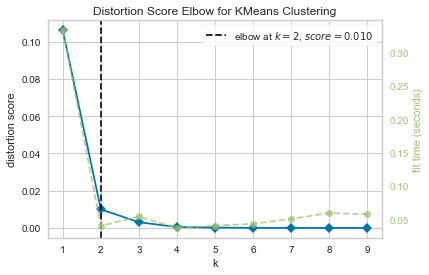

In [9]:
file_name = exp_config.ANALYSIS_PATH + "elbow_curve_weights_encoder_final_epoch_{}.jpg".format(epochs_completed)
significant_dimensions, cluster_centers_lv = get_significant_dimensions(max_abs_for_each_lv_dimension_weight,
                                                    file_name=file_name)
print(significant_dimensions)
#max_abs_for_each_lv_dimension_weight = np.squeeze(max_abs_for_each_lv_dimension_weight)

# Decoder parameters

In [10]:
decoder_keys = [k for  k in decoder_params]
print(decoder_keys)

['decoder/de_fc1/Matrix:0', 'decoder/de_fc1/bias:0', 'decoder/de_dc3/w:0', 'decoder/de_dc3/biases:0', 'decoder/de_dc4/w:0', 'decoder/de_dc4/biases:0']


## Decoder layer 1

[0.20029053] [0.34741524] [0.5765163]


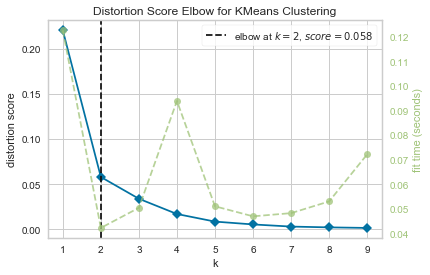

In [11]:
de_conv_weights_fc1 = decoder_params["decoder/de_fc1/Matrix:0"]
max_abs_for_each_out_dimension_weight = find_absolute_largest_weights(weights=de_conv_weights_fc1,
                                                                      num_out_units = exp_config.num_units[2]
                                                                     )
file_name = exp_config.ANALYSIS_PATH + "elbow_curve_weights_decoder_first_epoch_{}.jpg".format(epochs_completed)

significant_dimensions_decoder_fc1 = get_significant_dimensions(max_abs_for_each_out_dimension_weight,
                                                    file_name=file_name
                                                   )
max_abs_for_each_out_dimension_weight = np.squeeze(max_abs_for_each_out_dimension_weight)


In [12]:
de_conv_weights_dc4 = decoder_params["decoder/de_dc4/w:0"]
de_conv_bias_dc4 = decoder_params["decoder/de_dc4/biases:0"]

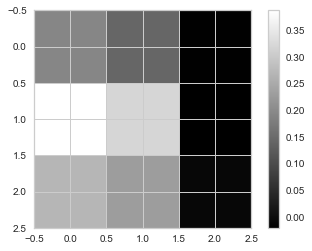

In [13]:
plt.imshow(np.squeeze(de_conv_weights_dc4[:, :, 0, 3]),cmap="gray")
plt.colorbar()

In [14]:
de_fc_weights = decoder_params["decoder/de_fc1/Matrix:0"]
de_fc_bias = decoder_params["decoder/de_fc1/bias:0"]

In [15]:
unused_features = []
for i in range(de_conv_weights_dc4.shape[3]):
    max_weight = np.max(np.squeeze(de_conv_weights_dc4[:, :, 0, i]))
    if max_weight <= 0.02:
        unused_features.append(i)
print(len(unused_features),
      unused_features)
    

20 [0, 2, 6, 11, 16, 18, 19, 21, 23, 25, 28, 29, 30, 34, 35, 38, 45, 52, 53, 55]


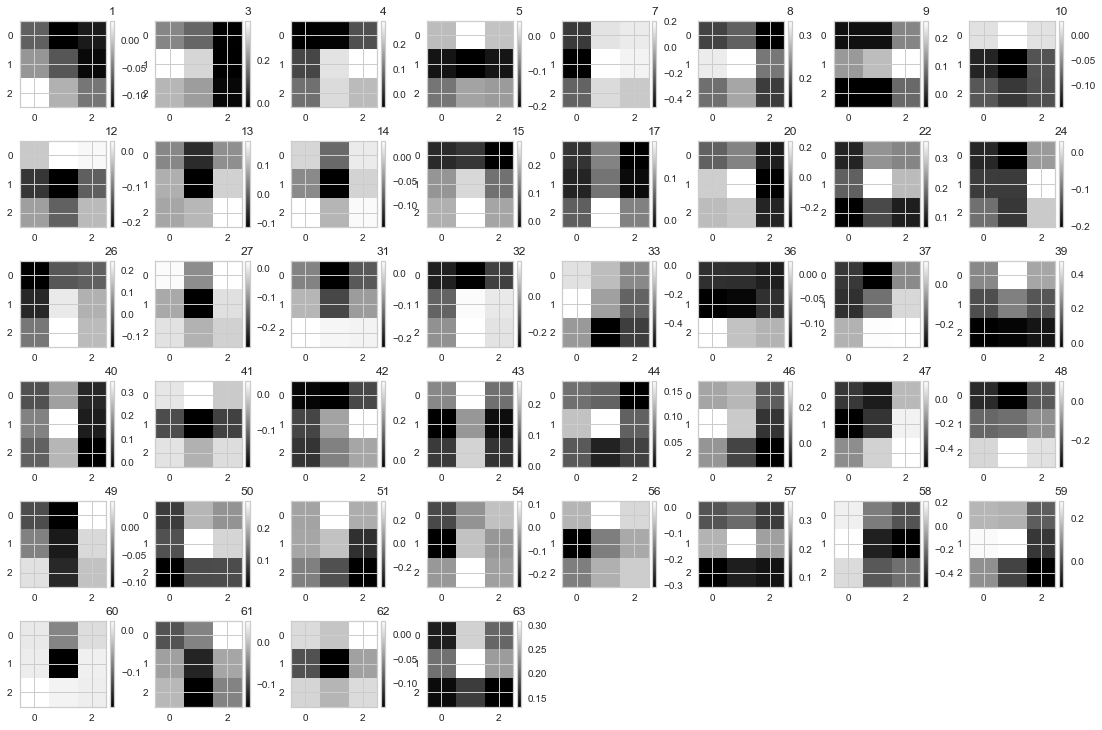

In [16]:
fig = plt.figure(figsize=(15, 10))
filter_num = 0
for i in range(de_conv_weights_dc4.shape[3]):
    if  i in unused_features:
        continue
    weights = np.squeeze(de_conv_weights_dc4[:, :, 0, i])
    ax = fig.add_subplot(6, 8, filter_num + 1)
    filter_num += 1
    plt.imshow(weights, cmap="gray")
    divider = make_axes_locatable(ax)
    cax1= divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    plt.title(str(i))
fig.tight_layout(pad=0.05)

# Load Validation images

In [17]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
train_val_iterator, val_images, val_labels, manual_annotation_np = load_images(exp_config,
                                                                    "val",
                                                                    manual_annotation_file)
unique_labels = train_val_iterator.get_unique_labels()
num_batches = val_images.shape[0] / exp_config.BATCH_SIZE
val_labels= np.argwhere(val_labels == 1)[:,1]

Warning /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/analysis/manual_annotation_epoch_9.0.csv path does not exist. Creating random prior with uniform distribution


# Get the Statistics of features at all levels

In [18]:
if recompute_feature_vectors:
    exp = Experiment(1, "VAE_MNIST", 128, exp_config, run_id)
    train_val_data_iterator = TrainValDataIterator.from_existing_split(exp.config.split_name,
                                                                       exp.config.DATASET_PATH,
                                                                       exp.config.BATCH_SIZE,
                                                                       manual_labels_config=exp.config.manual_labels_config,
                                                                       manual_annotation_file=None)

    model = None
    tf.reset_default_graph()
    train_df = None
    recompute_feature_vectors = False
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
            model = ClassifierModel(exp_config,
                                    sess,
                                    epoch=1,
                                    batch_size=BATCH_SIZE,
                                    z_dim=z_dim,
                                    dataset_name=DATASET_NAME,
                                    beta = exp_config.beta,
                                    num_units_in_layer=exp_config.num_units,
                                    log_dir=exp_config.LOG_PATH,
                                    checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                    result_dir=exp_config.PREDICTION_RESULTS_PATH
                                   )
            exp.model = model
            train_val_data_iterator.reset_counter("train")
            train_val_data_iterator.reset_counter("val")
            train_df = exp.encode_latent_vector_and_get_features(train_val_data_iterator,
                                                                 int(epochs_completed),
                                                                 "train",
                                                                 save_results=True)


In [20]:
# Load latent vectors for train data
n_3 = exp_config.num_units[exp_config.num_decoder_layer - 2]
n_2 = exp_config.num_units[exp_config.num_decoder_layer - 3]

z_stats = dict()
l3_stats = dict()

z_stats_given_label = dict()
l3_stats_given_label = dict()


filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, l3_col_names = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
train_latent_vectors_mean_by_label = dict()
train_latent_vectors_std_by_label = dict()
train_l3_vectors_mean_by_label = dict()
train_l3_vectors_std_by_label = dict()

for z_col_name in z_col_names:
    z_stats[z_col_name] = df[z_col_name].describe()
for l3_col_name in l3_col_names:
    l3_stats[l3_col_name] = df[l3_col_name].describe()

for label in unique_labels:
    z_stats_given_label[label] = dict()
    l3_stats_given_label[label] = dict()
    df_for_label = df[df["label"] == label]
    for z_col_name in z_col_names:
        z_stats_given_label[label][z_col_name] = df_for_label[z_col_name].describe()
    for l3_col_name in l3_col_names:
        l3_stats_given_label[label][l3_col_name] = df_for_label[l3_col_name].describe()
    train_latent_vectors_mean_by_label[label] = df_for_label[z_col_names].mean()
    train_latent_vectors_std_by_label[label] = df_for_label[z_col_names].std()
    

train_latent_vectors = df[z_col_names].values

In [21]:
print("Latent vectors shape",train_latent_vectors.shape)

for z_col_name in z_col_names:
    z_min =z_stats[z_col_name]["min"]
    z_max =z_stats[z_col_name]["max"]
    z_std =z_stats[z_col_name]["std"]
    print(f"feature_column_name ={z_col_name}\tmin={round(z_min,2)}\t\tmax={round(z_max,2)}\tstd={round(z_std,2)}")
    

for l3_col_name in l3_col_names:
    z_min =l3_stats[l3_col_name]["min"]
    z_max =l3_stats[l3_col_name]["max"]
    z_std =l3_stats[l3_col_name]["std"]
    print(f"feature_column_name ={l3_col_name}\tmin={round(z_min,2)}\t\tmax={round(z_max,2)}\tstd={round(z_std,2)}")


Latent vectors shape (59840, 10)
feature_column_name =z_0	min=-4.02		max=4.08	std=0.99
feature_column_name =z_1	min=-3.95		max=3.8	std=1.0
feature_column_name =z_2	min=-4.46		max=4.87	std=0.99
feature_column_name =z_3	min=-4.02		max=3.55	std=1.0
feature_column_name =z_4	min=-4.46		max=4.23	std=0.99
feature_column_name =z_5	min=-4.31		max=4.77	std=0.99
feature_column_name =z_6	min=-4.08		max=3.66	std=0.98
feature_column_name =z_7	min=-4.01		max=4.38	std=0.97
feature_column_name =z_8	min=-4.28		max=4.07	std=0.97
feature_column_name =z_9	min=-3.63		max=3.62	std=1.0
feature_column_name =l3_0	min=-1.26		max=5.59	std=0.89
feature_column_name =l3_1	min=-1.33		max=5.68	std=0.9
feature_column_name =l3_2	min=-1.15		max=4.54	std=1.15
feature_column_name =l3_3	min=-0.73		max=5.74	std=0.93
feature_column_name =l3_4	min=-1.92		max=0.95	std=0.29
feature_column_name =l3_5	min=-0.69		max=5.39	std=1.0
feature_column_name =l3_6	min=-1.8		max=4.3	std=0.97
feature_column_name =l3_7	min=-0.55		max=7.45	std=

## Encode and Decode validation images. Get the latent vectors and reconstructed images

In [22]:
model = None
tf.reset_default_graph()
val_latent_vectors_by_label = []
val_mu_by_label = []
val_sigma_by_label = []

reconstructed_images = []
images_by_label = []
val_decoder_features = defaultdict(list)
val_encoder_features = defaultdict(list)

reconstructed_images_from_l3 = []
train_l3_vectors_mean_by_label = np.zeros((len(unique_labels), len(l3_col_names)))

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=exp_config.BATCH_SIZE,
                                z_dim=z_dim,
                                dataset_name=exp_config.dataset_name,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        for d in range(len(unique_labels)):
            #mean l3  for training images
            df_for_label = df[df["label"] == d]
            train_l3_vectors_mean_by_label[d] = df_for_label[l3_col_names].mean().values
            #train_l3_vectors_std_by_label[d] = df_for_label[l3_col_names].std().values

            # validation images
            indices = np.argwhere(val_labels == d)
            images_by_label.append(val_images[indices])
            mus, sigmas, zs, dense2_ens, reshapeds, conv2_ens, conv1_ens = encode_and_get_features(model,
                                                                                                   np.squeeze(val_images[indices],
                                                                                                              axis=1),
                                                                                                   exp_config.BATCH_SIZE,
                                                                                                   exp_config.Z_DIM)
            val_encoder_features["dense_2"].append(dense2_ens)
            val_encoder_features["mu"].append(mus)
            val_encoder_features["sigma"].append(sigmas)
            val_latent_vectors_by_label.append(zs)
            
            recon_images,dense1_de, dense2_de, reshaped_de, deconv1_de = decode_and_get_features(model,
                                                                                                 val_latent_vectors_by_label[-1],
                                                                                                 exp_config.BATCH_SIZE)
            reconstructed_images.append( recon_images )
            recon_images_l3 = decode_l3(model, dense2_ens, exp_config.BATCH_SIZE)
            reconstructed_images_from_l3.append(recon_images_l3)
            
            val_decoder_features["dense_2"].append(dense2_de)
            val_decoder_features["dense_1"].append(dense1_de)
            val_decoder_features["deconv_1"].append(deconv1_de)
            
        reconstructed_images_from_mean_l3 = decode_l3(model, train_l3_vectors_mean_by_label, exp_config.BATCH_SIZE)

            

tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
Number of steps completed=9351
Number of epochs completed 10.0


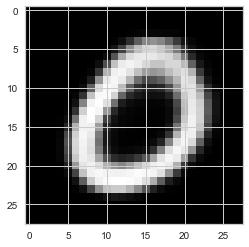

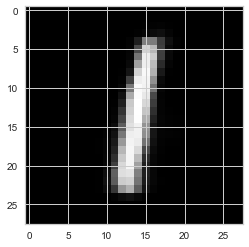

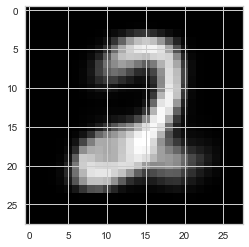

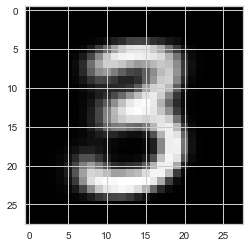

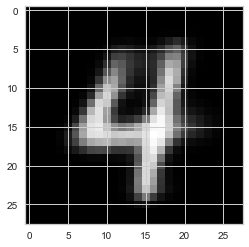

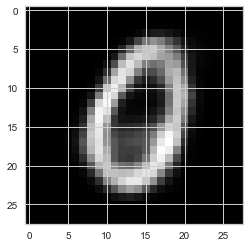

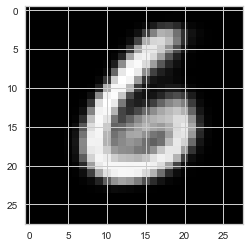

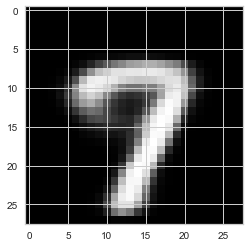

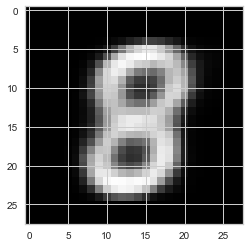

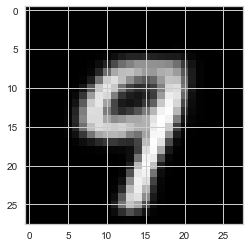

<Figure size 432x288 with 0 Axes>

In [23]:
display_images(reconstructed_images_from_mean_l3)

In [24]:
def apply_activation(x, activation):
    if activation == "linear":
        return x
    elif activation == "lrelu":
        return np.where(x > 0, x, x * LEAK)

# Analyse final layer of encoder

In [25]:
def normalize(v):
    return v / np.linalg.norm(v)

def min_max_normalize(v):
    maximum = np.max(v)
    minimum = np.min(v)
    if maximum > 0:
        normalized = np.where(v > 0,v/maximum, v)
    if minimum > 0:
        normalized = np.where(normalized < 0,normalized/maximum, normalized)
    return normalized

        

In [26]:
from collections.abc import Iterable
def plot_layer_weights_input_and_output(z_dim, w_fc4, bias_fc4, f, dimensions, lower_confidence, upper_confidence):
    if not isinstance(dimensions, Iterable):
        dimensions = [dimensions]
    for dim in dimensions:
        plt.figure(figsize=(15,10))
        plt.title(f"Output unit {dim}")

        plt.plot(min_max_normalize(w_fc4[:,dim] ))
        out = np.asarray(w_fc4[:,dim] * f)
        out_with_bias = np.append(out, bias_fc4[dim])
        output = apply_activation(np.sum(out_with_bias), activation)

        plt.plot(min_max_normalize(out_with_bias))
        #TODO plot output after activation also
        plt.plot([output] * 33)
        #plt.plot([np.sum(out_with_bias)/np.linalg.norm(out_with_bias)] * 33)
        
        ax = plt.gca()
        
        x = list(range(0, 30,1))
        print("Norm of out_with_bias",np.linalg.norm(out_with_bias))

        ax.fill_between(x,
                        lower_confidence/np.linalg.norm(out_with_bias),
                        upper_confidence/np.linalg.norm(out_with_bias),
                        color='b',
                        alpha=.1)
        print(f"Output unit {dim} value", output)
        
        plt.plot(min_max_normalize(f))
        plt.legend(["Weights", "Weights * Input","unit output", "Input"])
        
        #ax2 = ax.twinx()
        #ax2.plot(f)


Norm of out_with_bias 0.9551869172987222
Output unit 3 value -0.49238164211307245


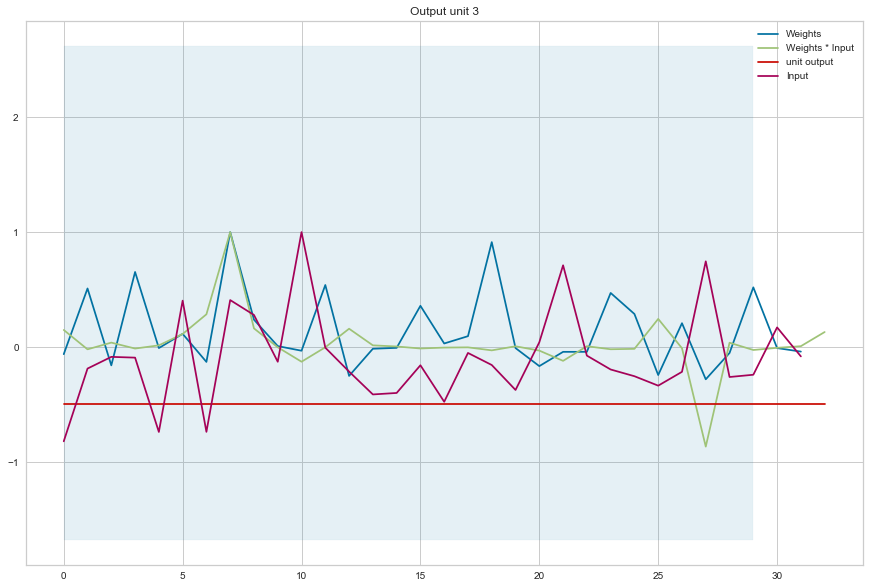

In [27]:
w_fc4 = encoder_params["encoder/en_fc4/Matrix:0"]
bias_fc4 = encoder_params["encoder/en_fc4/bias:0"]
activation = "linear"
plot_all_dimensions = False
val_sample_id = 0
digit = 9
# 32 dimensional encoding for digit `digit` validation sample id 0
f = val_encoder_features["dense_2"][digit][val_sample_id]
plot_layer_weights_input_and_output(z_dim, w_fc4, bias_fc4, f, significant_dimensions[0], -1.6, 2.5)


## Plot weights, input and output for mean feature for a given label

Norm of out_with_bias 0.6342553103945919
Output unit 3 value -0.6195582908808666


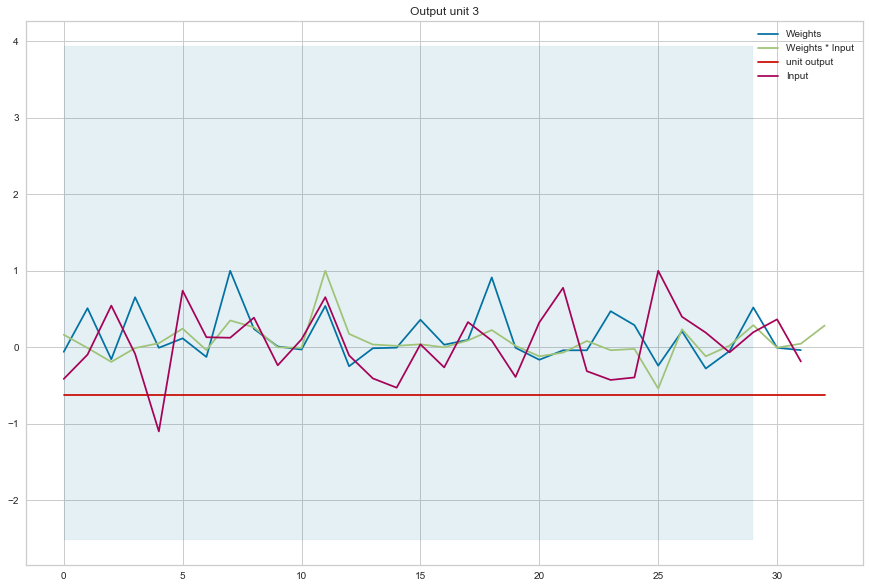

In [28]:
plot_all_dimensions = False
label = 9

# 32 dimensional encoding for label `label` 
df_for_label = df[df["label"] == label]
f = df_for_label[l3_col_names].mean()
plot_layer_weights_input_and_output(z_dim, w_fc4, bias_fc4, f, significant_dimensions[0], -1.6, 2.5)


In [29]:
# Encoder and decoder features for various inputs in validation set

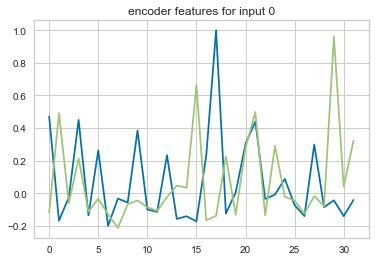

In [30]:
plt.figure()
for d in range(len(unique_labels)):
    num_images = len(images_by_label[d])
    features_en= val_encoder_features["dense_2"][d][0]
    features_en = features_en / np.max(features_en)
    features_de = val_decoder_features["dense_1"][d][0]
    plt.plot(features_en)
    plt.plot(features_de[0])
    plt.title(f"encoder features for input {d}")
    break


In [31]:
num_images = len(images_by_label[0])
features_de = val_decoder_features["deconv_1"][d][0][0:num_images]

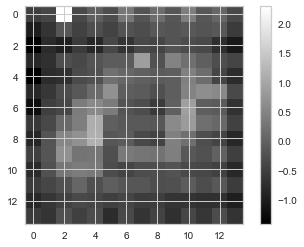

In [32]:
plt.imshow(np.squeeze(features_de[0, :, :, 3]),cmap="gray")
plt.colorbar()

(6272, 32)
[0.4088697] [0.65305454] [0.62608814]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


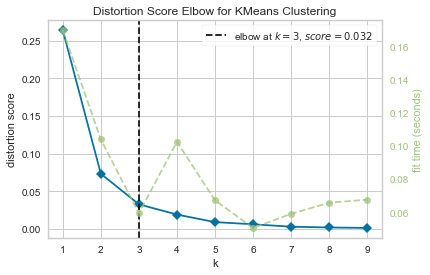

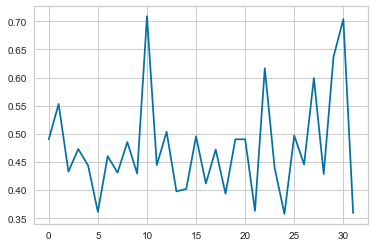

In [33]:
fc3_weights = encoder_params["encoder/en_fc3/Matrix:0"]
print(fc3_weights.shape)
max_abs_for_each_l3_dimension_weight = find_absolute_largest_weights(weights=fc3_weights,
                                                                     num_out_units=fc3_weights.shape[1]
                                                                    )
file_name = exp_config.ANALYSIS_PATH + "elbow_curve_weights_encoder_l3_epoch_{}.jpg".format(epochs_completed)
significant_dimensions_fc3, cluster_centers_l3 = get_significant_dimensions(max_abs_for_each_l3_dimension_weight,
                                                    file_name=file_name)
print(significant_dimensions_fc3)
max_abs_for_each_l3_dimension_weight = np.squeeze(max_abs_for_each_l3_dimension_weight)
plt.figure()
plt.plot(max_abs_for_each_l3_dimension_weight)


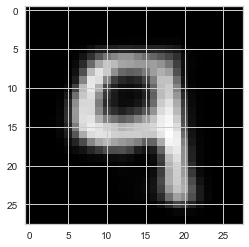

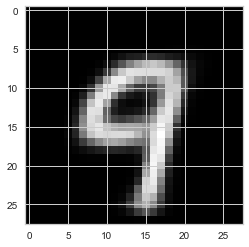

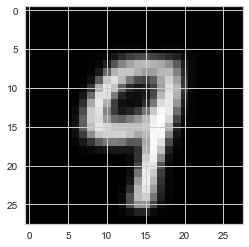

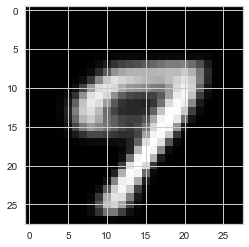

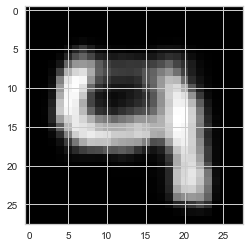

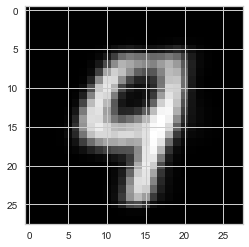

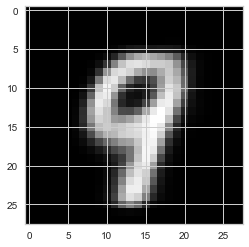

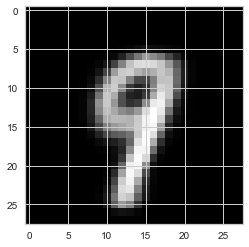

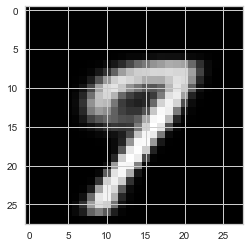

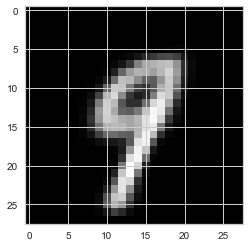

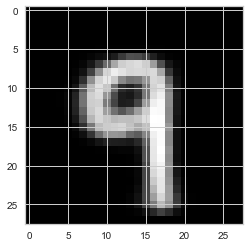

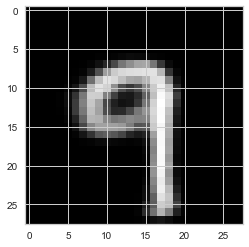

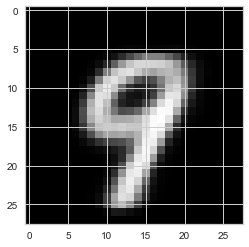

<Figure size 432x288 with 0 Axes>

In [34]:
display_images(reconstructed_images[9])

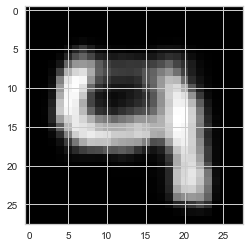

<Figure size 432x288 with 0 Axes>

In [35]:
display_images(reconstructed_images[9][4:5])

In [36]:
val_latent_vectors_by_label[d][0]

array([ 0.80627388, -1.95752811,  0.02550264, -0.73842895,  0.64804602,
        0.07780841,  1.24373782, -0.14618294, -0.61984938, -1.67640603])

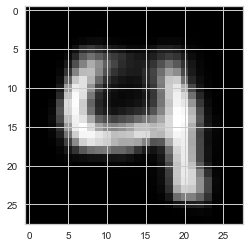

<Figure size 432x288 with 0 Axes>

In [37]:
display_images(reconstructed_images_from_l3[9][4:5])

In [38]:
val_latent_vectors_by_label[9][4]

array([-0.48329967,  3.30149388, -1.35585272,  1.42547631, -0.69158363,
        0.83276659, -2.14918542,  0.08839881, -1.01368594, -1.61637843])

In [39]:
val_encoder_features["dense_2"][9][4]

array([-0.73394752,  0.23031425, -0.36446065,  1.95150721, -0.31953165,
        0.80323416, -0.6212098 ,  3.46333027,  1.18439162, -0.34812224,
        5.50517368, -0.16756915, -0.40284038, -0.49111858, -0.29194599,
       -0.27249804, -0.40861264, -0.02678142,  0.98382902, -0.14738938,
        0.70934916,  3.32029033, -0.20760922, -0.23250437,  2.40034032,
       -0.45645186, -0.1942445 ,  3.52039599,  0.18570858, -0.01766399,
        1.32740915, -0.2518186 ])

In [40]:
cluster_centers_l3

array([[0.49190158],
       [0.4088697 ],
       [0.65305454]], dtype=float32)

In [48]:
mu = val_encoder_features["mu"][9][0]
sigma = val_encoder_features["sigma"][9][0]

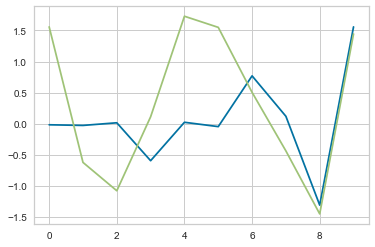

In [49]:
plt.plot(val_encoder_features["mu"][9][8])
plt.plot(val_latent_vectors_by_label[9][8])

In [50]:
z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

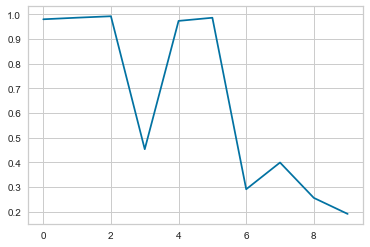

In [51]:
plt.plot(sigma)

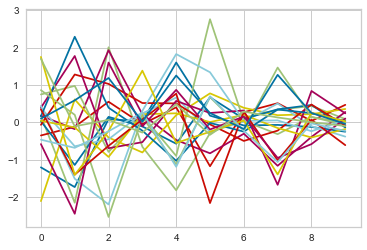

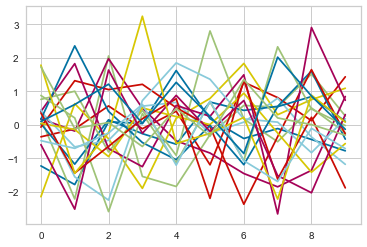

In [53]:
sigma = val_encoder_features["sigma"][9][8]
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    normal_t = tf.random_normal((20,10), 0, 1,dtype=tf.float32)
    normal = sess.run(normal_t)

for i in range(normal.shape[0]):
    plt.plot(sigma * normal[i])
    
plt.figure()
for i in range(normal.shape[0]):
    plt.plot( normal[i])


In [ ]:
# for i  in range(latent_vectors.shape[0]):
#     plt.plot(latent_vectors[i])
#     plt.figure()

In [ ]:
# print(reconstructed_images.shape)
# for i in range(reconstructed_images.shape[0]):
#     plt.imshow(np.squeeze(reconstructed_images[i]), cmap="gray")
#     plt.figure()

In [ ]:
# def trace_dim(mu, num_trace_steps,  dim):    
#     z = np.zeros([num_trace_steps , z_dim])
#     for i in range(num_trace_steps):
#         z[i] = mu
#     z_min =  -5
#     z_max = 5
        
#     step = 1 / num_trace_steps
#     for i in range(num_trace_steps):
#         alpha_i = step * i
#         z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
#     return z

In [54]:
len(val_encoder_features["dense_2"][1])

14

In [55]:
l3_dim = len(l3_col_names)

In [56]:
num_trace_steps = 36
tf.reset_default_graph()
reconstructed_deformed_images_l3 = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = ClassifierModel(
                            exp_config,
                            sess,
                            epoch=1,
                            batch_size=exp_config.BATCH_SIZE,
                            z_dim=z_dim,
                            dataset_name=exp_config.dataset_name,
                            beta = exp_config.beta,
                            num_units_in_layer=exp_config.num_units,
                            log_dir=exp_config.LOG_PATH,
                            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                            result_dir=exp_config.PREDICTION_RESULTS_PATH
                           )
    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    for d in range(len(unique_labels)):
        num_latent_vectors = 0
        total_latent_vectors =  l3_dim * num_trace_steps
        if total_latent_vectors < exp_config.BATCH_SIZE:
            total_latent_vectors = exp_config.BATCH_SIZE
        l3 = np.zeros([total_latent_vectors, l3_dim])
        for dimension in range(l3_dim):
            # TODO compute this for all images with each label
            l3_min = l3_stats[l3_col_names[dimension]]["min"]
            l3_max = l3_stats[l3_col_names[dimension]]["max"]
            traced_from_to = trace_dim(val_encoder_features["dense_2"][d][0], num_trace_steps, dimension, l3_dim, l3_min,l3_max)
            for i in range(num_trace_steps):
                l3[num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
        reconstructed_deformed_images_l3.append(decode_l3(model, l3, exp_config.BATCH_SIZE))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
Check point counter 9351

In [57]:
val_latent_vectors_by_label

[array([[ 8.06273878e-01, -1.95752811e+00,  2.55026408e-02,
         -7.38428950e-01,  6.48046017e-01,  7.78084099e-02,
          1.24373782e+00, -1.46182939e-01, -6.19849384e-01,
         -1.67640603e+00],
        [ 2.43717611e-01,  4.17681217e-01,  3.90406519e-01,
          4.30156410e-01, -7.77734458e-01, -4.61625636e-01,
          4.85097677e-01, -3.00837457e-02, -1.96188533e+00,
         -1.96656168e+00],
        [ 7.48956501e-01, -2.10518226e-01,  2.39595985e+00,
         -1.32838726e+00, -6.74345732e-01, -1.78444779e+00,
         -1.01704383e+00,  1.50170296e-01,  6.61740422e-01,
         -1.64117694e+00],
        [ 6.21720403e-03, -2.18564961e-02, -1.12000585e+00,
         -2.00246334e-01, -2.38831446e-01, -4.60475117e-01,
          2.15702146e-01, -1.10692668e+00, -8.64791751e-01,
         -1.62278473e+00],
        [ 1.48609614e+00, -6.78318590e-02, -8.29996943e-01,
         -5.63568056e-01, -9.54279363e-01, -1.73012352e+00,
          1.24273813e+00,  7.01725706e-02, -1.982981

In [58]:
num_trace_steps = 36
tf.reset_default_graph()
reconstructed_deformed_images = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = ClassifierModel(
                            exp_config,
                            sess,
                            epoch=1,
                            batch_size=exp_config.BATCH_SIZE,
                            z_dim=z_dim,
                            dataset_name=exp_config.dataset_name,
                            beta = exp_config.beta,
                            num_units_in_layer=exp_config.num_units,
                            log_dir=exp_config.LOG_PATH,
                            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                            result_dir=exp_config.PREDICTION_RESULTS_PATH
                           )
    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    for d in range(len(unique_labels)):
        num_latent_vectors = 0
        total_latent_vectors =  z_dim * num_trace_steps
        if total_latent_vectors < exp_config.BATCH_SIZE:
            total_latent_vectors = exp_config.BATCH_SIZE
        z = np.zeros([total_latent_vectors, z_dim])
        for dimension in range(z_dim):
            # TODO compute this for all images with each label
            z_min = z_stats[z_col_names[dimension]]["min"]
            z_max = z_stats[z_col_names[dimension]]["max"]

            traced_from_to = trace_dim(val_latent_vectors_by_label[d][0], num_trace_steps, dimension, z_dim, z_min, z_max)
            for i in range(num_trace_steps):
                z[num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
        reconstructed_deformed_images.append(decode(model, z, exp_config.BATCH_SIZE))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-9351
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/un_supervised_classification_z_dim_10/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-9351
 [*] Success to read ClassifierModel.model-9351
 [*] Load SUCCESS
Check point counter 9351

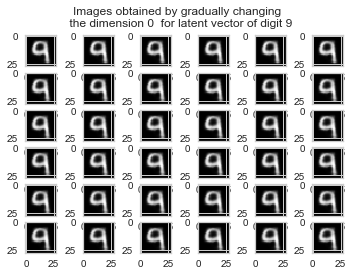

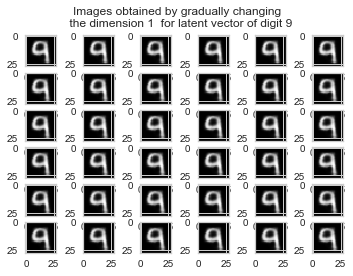

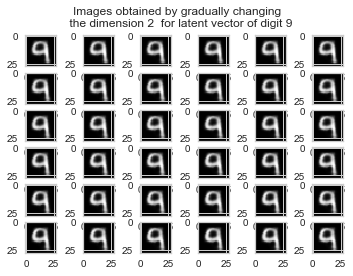

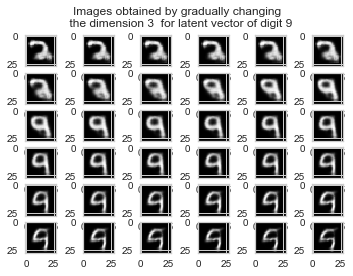

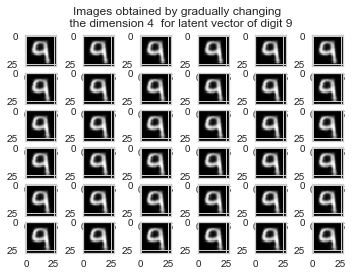

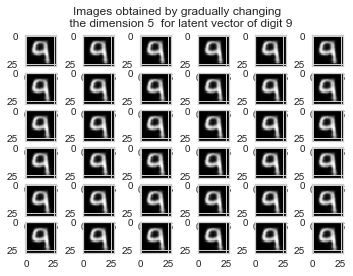

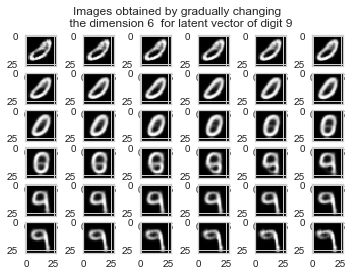

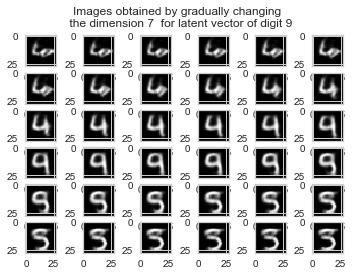

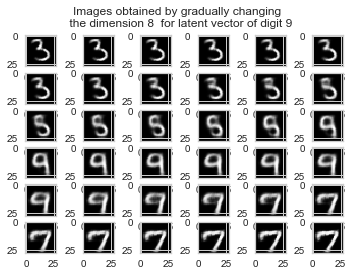

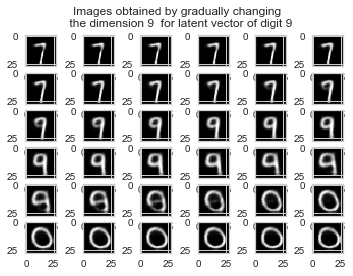

In [59]:
# d = 9
# title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
# for dim in range(10):
#     fig = plt.figure()
#     fig.suptitle(title_string.format(dim,d))
#     for i in range(num_trace_steps):
#         ax = fig.add_subplot(6, 6, i + 1)
#         ax.imshow(np.squeeze(reconstructed_deformed_images[d][dim * num_trace_steps + i]), cmap="gray")
#     #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


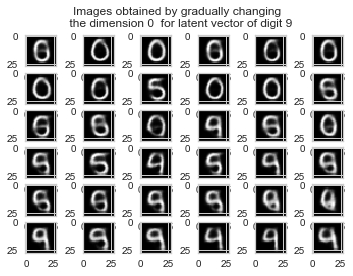

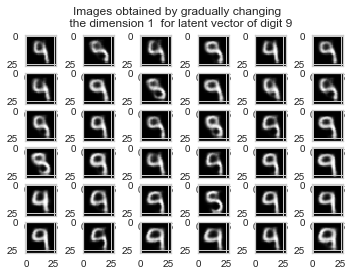

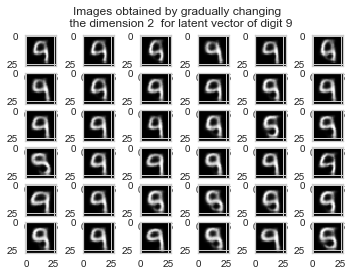

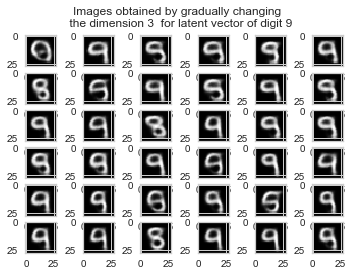

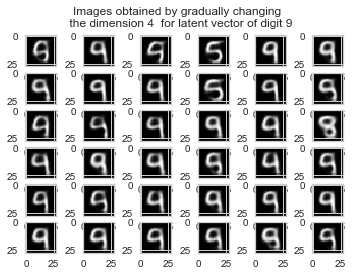

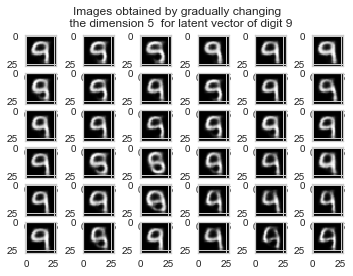

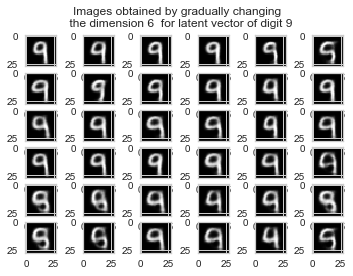

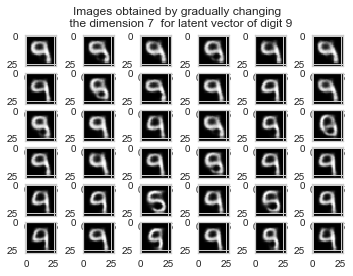

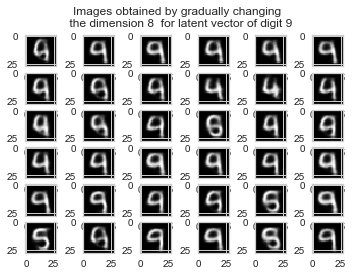

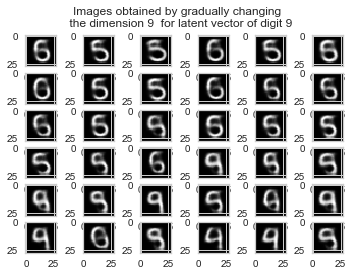

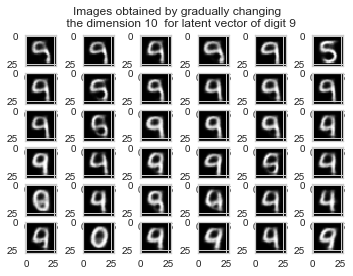

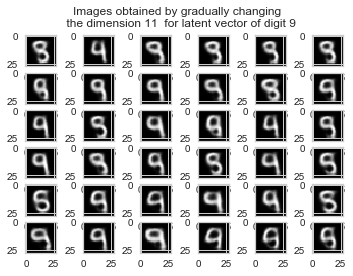

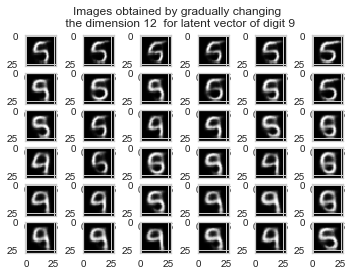

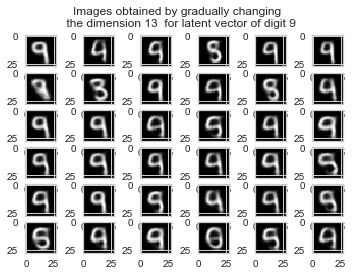

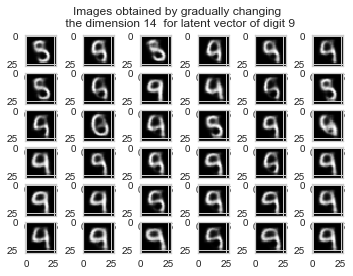

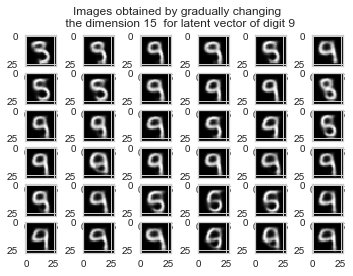

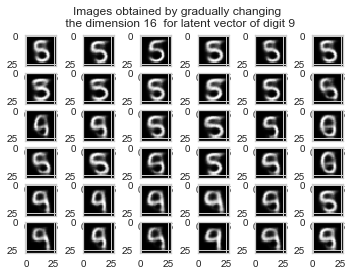

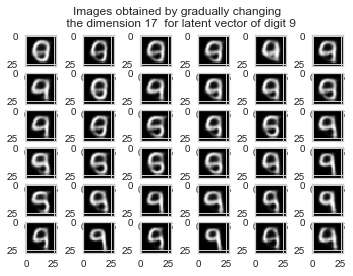

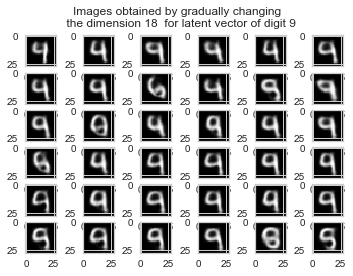

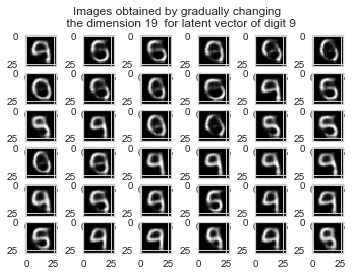

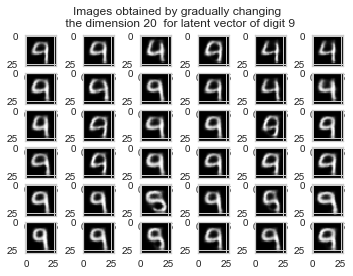

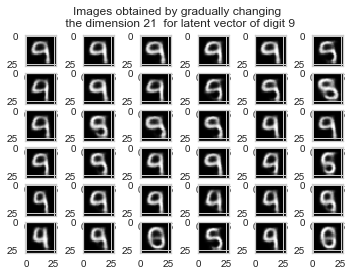

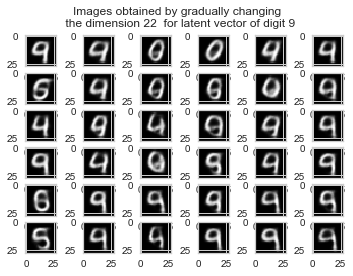

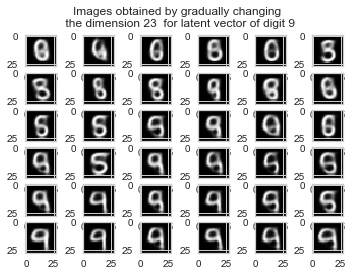

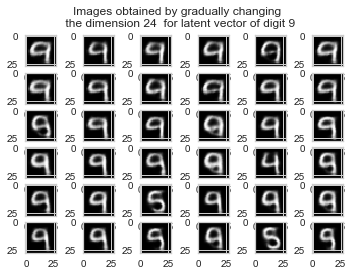

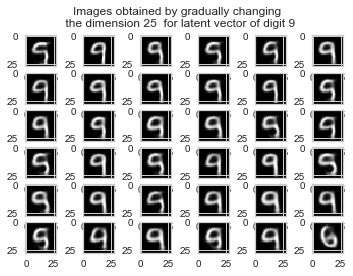

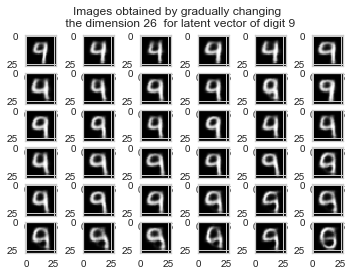

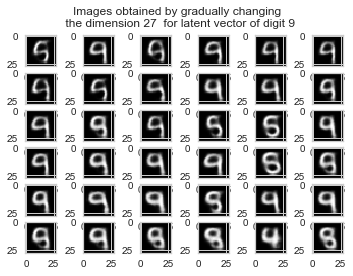

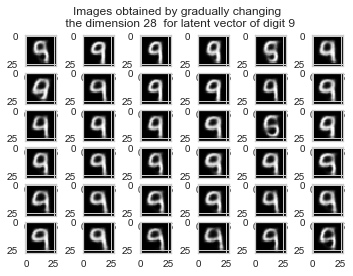

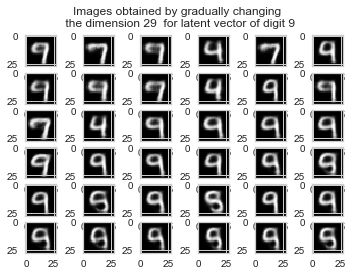

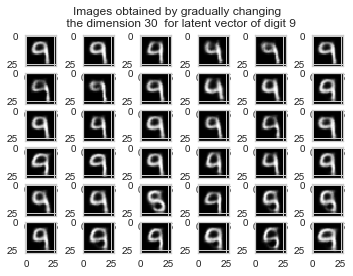

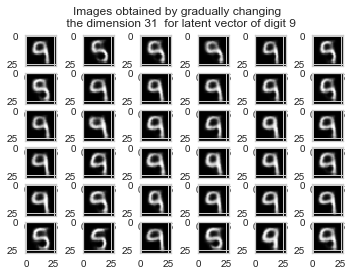

In [60]:
# d = 9
# title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
# for dim in range(l3_dim):
#     fig = plt.figure()
#     fig.suptitle(title_string.format(dim,d))
#     for i in range(num_trace_steps):
#         ax = fig.add_subplot(6, 6, i + 1)
#         ax.imshow(np.squeeze(reconstructed_deformed_images_l3[d][dim * num_trace_steps + i]), cmap="gray")
#     #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

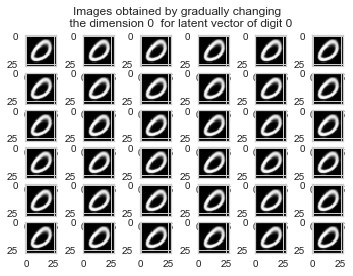

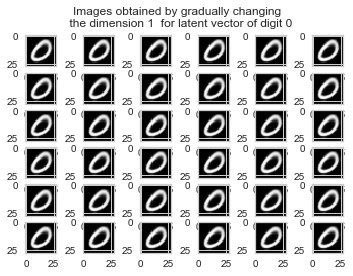

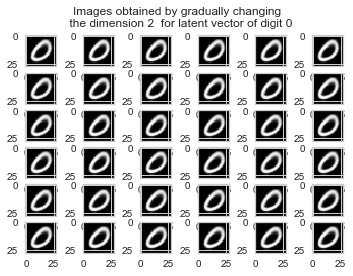

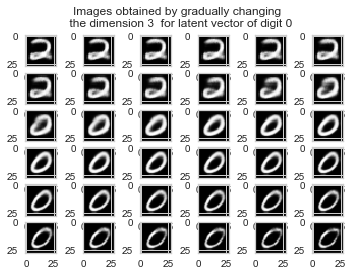

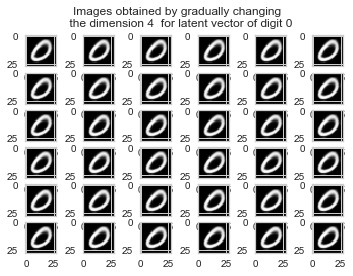

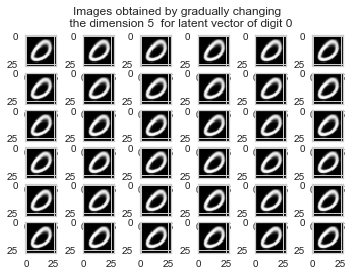

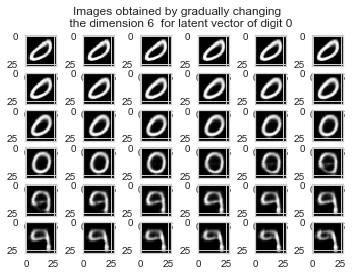

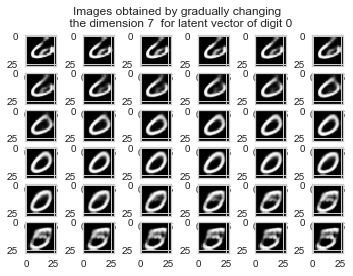

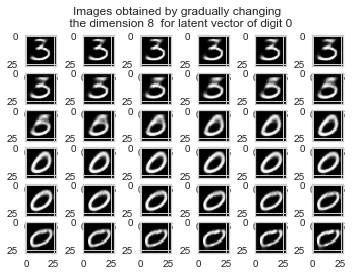

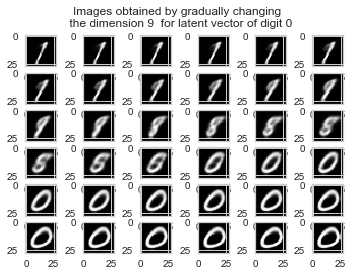

In [61]:
# d = 0
# title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
# for dim in range(10):
#     fig = plt.figure()
#     fig.suptitle(title_string.format(dim,d))
#     for i in range(num_trace_steps):
#         ax = fig.add_subplot(6, 6, i + 1)
#         ax.imshow(np.squeeze(reconstructed_deformed_images[d][dim * num_trace_steps + i]), cmap="gray")
#     #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

In [62]:
sensitive_dimensions = {
                        0:[3,6,7,8,9],
                        1:[1,2,3,5,7,8,9],
                        2:[1,2,3,5,7,8,9],
                        3:[1,2,3,5,7,8,9],
                        4:[1,2,3,5,7,8,9],
                        5:[1,2,3,5,7,8,9],
                        6:[1,2,3,5,7,8,9],
                        7:[1,2,3,5,7,8,9],
                        8:[1,2,3,5,7,8,9],
                        9:[3,6,7,8,9]
                       }

In [63]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
for d, _latent_vectors in enumerate(val_latent_vectors_by_label):
#     if d != 0:
#         continue
    fig = plt.figure(figsize=(15,10))
    mean_0 = np.mean(_latent_vectors,
                     axis = 0)

    for i in range(_latent_vectors.shape[0]):
#         if i % 4 == 0:
#             fig = plt.figure(figsize=(15,10))
        
        print(_latent_vectors.shape)
#         ax = fig.add_subplot(2, 2, i % 4 + 1)
#         plt.plot(_latent_vectors[i][sensitive_dimensions[d]])
#         #plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
#         iax = inset_axes(ax, width="50%",height=1,loc=1)

#         #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
#         plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")
        

(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(14, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(13, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(12, 10)
(

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [64]:
train_latent_vectors.shape

(59840, 10)

In [65]:
mean_0.reshape([1,10])

array([[ 0.53699991,  0.09658832, -0.20066011, -0.51256469, -0.36116101,
         0.41084414, -0.80616946, -0.24329508, -0.74268189,  0.33243214]])

In [67]:
len(val_latent_vectors_by_label)

10

In [71]:
print(np.asarray(train_latent_vectors).shape )
print(np.asarray(val_latent_vectors_by_label).shape )
val_latent_vectors_by_label[1].shape

(59840, 10)
(10,)


(14, 10)

In [72]:
# val_latent_vectors = np.asarray(val_latent_vectors)
# val_latent_vectors = np.reshape(val_latent_vectors,(128, exp_config.Z_DIM))
# print(val_latent_vectors.shape)
# # print(train_latent_vectors.shape)
# # print(val_latent_vectors.shape)

In [74]:
# from sklearn.preprocessing import MinMaxScaler

# #reconstructed_image_for_means = plot_mean_latentvector(val_latent_vectors, [0, 9])
# reconstructed_image_for_means = plot_features(exp_config, features, digits, sensitive_dimensions,  True)
# scaler = MinMaxScaler()
# scaler.fit(train_latent_vectors)
# scaler.transform(val_latent_vectors)

# #plot_mean_latentvector(latent_vectors, 0, new_fig=False)

In [76]:
# reconstructed_image_for_means

In [79]:
# for reconstructed_image_for_mean in reconstructed_image_for_means:
#     plt.figure()
#     plt.imshow(np.squeeze(reconstructed_image_for_mean),cmap="gray")

In [81]:
# from mpl_toolkits.axes_grid.inset_locator import inset_axes
# for d, _latent_vectors in enumerate(latent_vectors):
#     if d != 9:
#         continue
#     fig = plt.figure(figsize=(15,10))

#     for i in range(_latent_vectors.shape[0]):
# #         if i % 4 == 0:
# #             fig = plt.figure(figsize=(15,10))
#         ax = fig.add_subplot(2, 2, i % 4 + 1)
#         plt.plot(_latent_vectors[i][sensitive_dimensions[d]])
#         #plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
#         iax = inset_axes(ax, width="50%",height=1,loc=1)

#         #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
#         plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")
        
        
        

In [82]:
# from mpl_toolkits.axes_grid.inset_locator import inset_axes
# for d, _latent_vectors in enumerate(latent_vectors):
#     if d != 9:
#         continue
#     fig = plt.figure(figsize=(15,10))

#     for i in range(_latent_vectors.shape[0]):
# #         if i % 4 == 0:
# #             fig = plt.figure(figsize=(15,10))
#         ax = fig.add_subplot(2, 2, i % 4 + 1)
#         plt.plot(_latent_vectors[i][sensitive_dimensions[d]])
#         #plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
#         iax = inset_axes(ax, width="50%",height=1,loc=1)

#         #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
#         plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")
        
        
        

In [84]:
# fig = plt.figure(figsize=(15,10))
# d1 = 0
# d2 = 9
# l1 = np.mean(latent_vectors[d1], axis=0)
# print(l1.shape)
# l2 = np.mean(latent_vectors[d2], axis=0)
# print(l2.shape)
# ax = fig.add_subplot(2, 2, i % 4 + 1)
# plt.plot(l1[sensitive_dimensions[d1]])
# plt.plot(l2[sensitive_dimensions[d2]])
# plt.legend([str(d1),str(d2)])

# #plt.xticks(list(range(len(sensitive_dimensions))),sensitive_dimensions[d])
# #iax = inset_axes(ax, width="50%",height=1,loc=1)

# #plt.axes([0.65, 0.65, 0.2, 0.2], facecolor='y')
# #plt.imshow(np.squeeze(reconstructed_images[d][i]),cmap="gray")


In [90]:
# model = None
# tf.reset_default_graph()
# latent_vectors_1 = np.zeros((5,z_dim))
# latent_vectors_1[0] = l1
# latent_vectors_1[1] = l2

# latent_vectors_1[2] = l2
# latent_vectors_1[2][6] = l1[6]


# latent_vectors_1[3] = l2
# latent_vectors_1[3][9] = l1[9]

# latent_vectors_1[4] = l2
# latent_vectors_1[4][6] = l1[6]
# latent_vectors_1[4][9] = l1[9]

# with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
#     model = ClassifierModel(exp_config,
#                             sess,
#                             epoch=1,
#                             batch_size=BATCH_SIZE,
#                             z_dim=z_dim,
#                             dataset_name=DATASET_NAME,
#                             beta = exp_config.beta,
#                             num_units_in_layer=exp_config.num_units,
#                             log_dir=exp_config.LOG_PATH,
#                             checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
#                             result_dir=exp_config.PREDICTION_RESULTS_PATH
#                            )
#     num_steps_completed = model.counter
#     print("Number of steps completed={}".format(num_steps_completed))
#     num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
#     epochs_completed = num_steps_completed // num_batches
#     print("Number of epochs completed {}".format(epochs_completed))
#     reconstructed_images_1 = decode(model, latent_vectors_1, exp_config.BATCH_SIZE)

# tf.reset_default_graph()


In [ ]:
# display_images(reconstructed_images_1)

In [ ]:
# fig = plt.figure()
# for i in range(2):
#     plt.plot(latent_vectors_1[i][sensitive_dimensions[d2]])

# for i in range(2,latent_vectors_1.shape[0]):
#     fig = plt.figure()
#     plt.plot(latent_vectors_1[i][sensitive_dimensions[d2]])


In [ ]:
# for i in range(2):
#     print(latent_vectors_1[i][sensitive_dimensions[d2]])

# for i in range(2,latent_vectors_1.shape[0]):
#     print(latent_vectors_1[i][sensitive_dimensions[d2]])


In [91]:
# from collections import defaultdict
# sensitive_dimensions_all_labels =[]
# sensitive_dimensions = defaultdict(list)

# for d in range(len(unique_labels)):
#     _reconstructed_deformed_images = reconstructed_deformed_images[d]
#     for dim in range(Z_DIM):
#         distances = []
#         for step_num in range(num_trace_steps):
#             distances.append(np.linalg.norm(np.squeeze(reconstructed_images[d][0]) - np.squeeze(_reconstructed_deformed_images[num_trace_steps * dim + step_num]) ))
#         max_distance = max(distances)
#         #print("Dimension {} Senssitivity {}".format(dim,max_distance))

#         if max_distance > 10:
#             sensitive_dimensions[d].append(dim)
#     #sensitive_dimensions_all_labels.append(sensitive_dimensions)
    

In [92]:
sensitive_dimensions

{0: [3, 6, 7, 8, 9],
 1: [1, 2, 3, 5, 7, 8, 9],
 2: [1, 2, 3, 5, 7, 8, 9],
 3: [1, 2, 3, 5, 7, 8, 9],
 4: [1, 2, 3, 5, 7, 8, 9],
 5: [1, 2, 3, 5, 7, 8, 9],
 6: [1, 2, 3, 5, 7, 8, 9],
 7: [1, 2, 3, 5, 7, 8, 9],
 8: [1, 2, 3, 5, 7, 8, 9],
 9: [3, 6, 7, 8, 9]}

In [ ]:
# plt.imshow(np.squeeze(reconstructed_images[0][0] ),cmap="gray")

In [93]:
# _reconstructed_deformed_images = reconstructed_deformed_images[0]

In [94]:
# sensitive_dimensions = defaultdict(list)
# d= 0
# _reconstructed_deformed_images = reconstructed_deformed_images[d]
# for dim in range(Z_DIM):
#     distances = []
#     for step_num in range(num_trace_steps):
#         deformed = np.squeeze(_reconstructed_deformed_images[num_trace_steps * dim + step_num])
#         plt.imshow(deformed,cmap="gray")
#         distance = np.linalg.norm(np.squeeze(reconstructed_images[d][0]) - deformed )
#         plt.title(f"{dim}_{num_trace_steps * dim + step_num}_{distance}")
#         plt.figure()
#         distances.append(distance)
#     max_distance = max(distances)
#     print("Dimension {} Senssitivity {}".format(dim,max_distance))

#     if max_distance > 10:
#         sensitive_dimensions[d].append(dim)

In [95]:
def insert_zeros(r,s):
    zero_inserted = np.zeros((s + 1) * r.shape[0])
    for i in range(r.shape[0]):
        zero_inserted[(s + 1) * i] = r[i]
    return zero_inserted

In [96]:
def deconv(a, k, stride):
    result_1 = np.zeros(tuple([stride * s for s in a.shape]))
    for  i  in range(a.shape[0]):
        ai_zero_inserted = insert_zeros(a[i], stride- 1)
        result_1[stride * i,:] = ai_zero_inserted
    return correlate2d(result_1, k)

# Find significant filters

In [97]:
def plot_output(out, threshold, fig_title=None):
    out_sigmoid = 1/(1 + np.exp(-out ))

    fig = plt.figure(figsize=(10,10))
    ax =  fig.add_subplot(2,2,1)
    plt.imshow(out, cmap="gray")
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title("Out")

    thresholded = np.zeros_like(out)
    thresholded[out > threshold] = 1
    ax = fig.add_subplot(2,2,2)
    plt.imshow(thresholded, cmap="gray")
    cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title(f"Thresholded at {threshold}")

    ax = fig.add_subplot(2,2,3)
    plt.imshow(out_sigmoid, cmap="gray")
    cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax1)
    ax.set_title("Sigmoid Output")
    
    if fig_title is not None:
        fig.suptitle(fig_title)

Text(0.5, 1.0, 'Sigmoid Output')

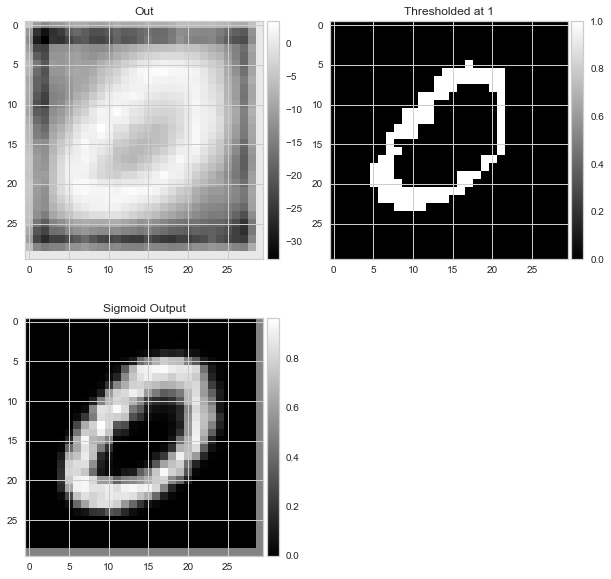

In [101]:
de_conv_weights_dc3 = decoder_params["decoder/de_dc4/w:0"]
de_conv_bias_dc3 = decoder_params["decoder/de_dc4/biases:0"]

h = features_de[0][:,:,i].shape[0]
w = features_de[0][:,:,i].shape[1]
stride = 2
padding = 1
num_filters = de_conv_weights_dc3.shape[3]
threshold = 1

deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights_dc3[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
out = deconvolved + de_conv_bias_dc3
#plot_output(out, 1)
out_sigmoid = 1/(1 + np.exp(-out ))

fig = plt.figure(figsize=(10,10))
ax =  fig.add_subplot(2,2,1)
plt.imshow(out, cmap="gray")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title("Out")

thresholded = np.zeros_like(out)
thresholded[out > threshold] = 1
ax = fig.add_subplot(2,2,2)
plt.imshow(thresholded, cmap="gray")
cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title(f"Thresholded at {threshold}")

ax = fig.add_subplot(2,2,3)
plt.imshow(out_sigmoid, cmap="gray")
cax1 = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax1)
ax.set_title("Sigmoid Output")

# if fig_title is not None:
#     fig.suptitle(fig_title)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  3.,  2.,  1.,  1.,  1.,  4.,  2.,  7.,
         5.,  4.,  2.,  4.,  3.,  6.,  5.,  4.,  5.,  5.,  9.,  7.,  5.,
         5.,  5.,  6.,  9.,  4.,  4.,  5.,  5., 11.,  9.,  5., 10., 10.,
        14., 10., 11., 12., 19., 14., 11., 17., 12., 16.,  8., 14., 19.,
        15., 12., 14., 10.,  9.,  6.,  8., 16., 14., 13., 15., 18., 12.,
        12.,  7., 11.,  7., 17., 11., 12., 18., 20.,  6.,  9., 19., 79.,
        19., 22., 28., 24., 31., 13., 12.,  6.,  1.]),
 array([-32.62628845, -32.2670758 , -31.90786315, -31.54865051,
        -31.18943786, -30.83022521, -30.47101257, -30.11179992,
        -29.75258728, -29.39337463, -29.03416198, -28.67494934,
        -28.31573669, -27.95652404, -27.5973114 , -27.23809875,
        -26.87888611, -26.51967346, -26.16046081, -25.80124817,
        -25.44203552, -25.08282288, -24.72361023, -24.36439758,
        -24.00518494, -23.64597229, -23.28675964, 

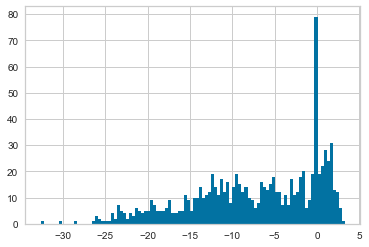

In [102]:
plt.hist(np.ravel(out),bins=100)

In [103]:
num_filters

64

# Plot individual featuremaps

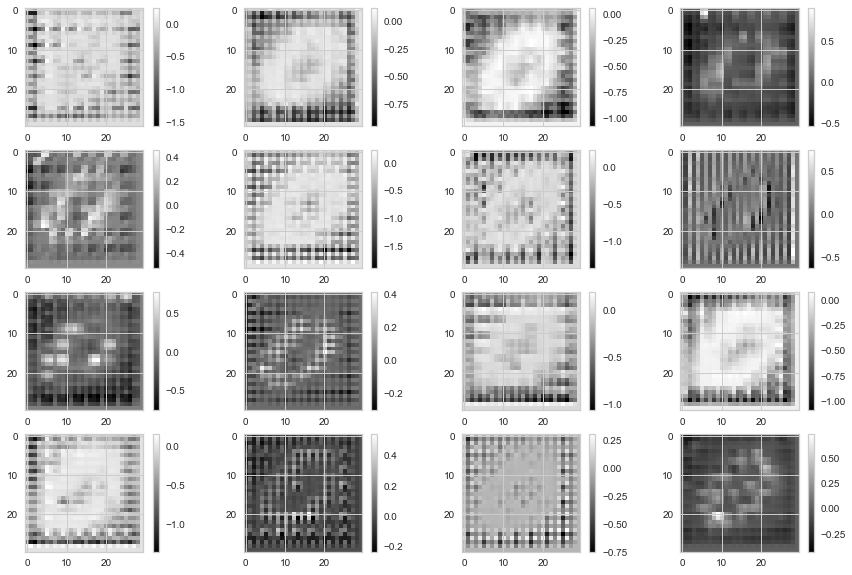

In [104]:

fig = plt.figure(figsize=(15,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.imshow(feature_maps[i],cmap="gray")
    plt.colorbar()

In [105]:
num_significant_filters = 20

filter_correlations = np.zeros(num_filters)
for filter_num in range(num_filters):
    m = np.corrcoef(feature_maps[filter_num].flat, out.flat)
    filter_correlations[filter_num] = m[0,1]
    
index_array = np.argsort(filter_correlations)
significant_filters = index_array[(num_filters- num_significant_filters):]
insignificant_filters = index_array[:(num_filters- num_significant_filters)]
print(significant_filters)

[61 55 31 12 40 29 30 18 35 16 23 25 44  1 36 45 34 19  2 11]


In [106]:
index_array

array([47, 33, 58, 37,  7, 20, 32, 51, 26, 17, 60, 13, 54, 14, 49, 52,  4,
       41, 63,  9, 46, 39, 62,  0, 42, 27, 53, 59,  3,  5, 48,  8, 22, 38,
        6, 21, 57, 15, 28, 24, 43, 56, 10, 50, 61, 55, 31, 12, 40, 29, 30,
       18, 35, 16, 23, 25, 44,  1, 36, 45, 34, 19,  2, 11])

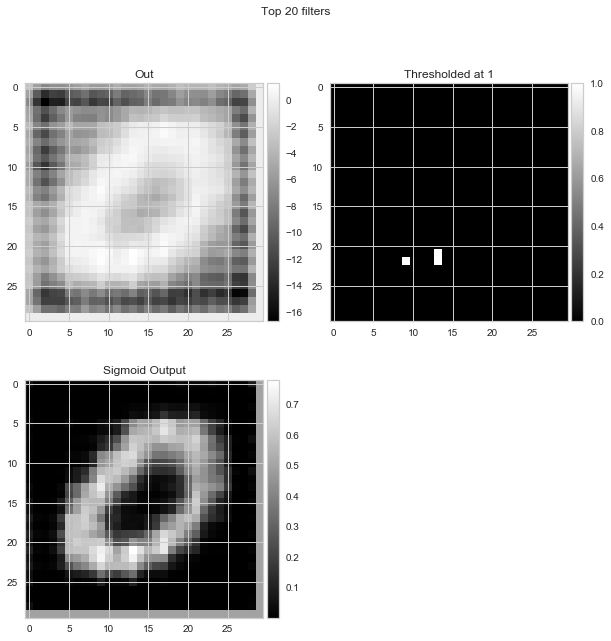

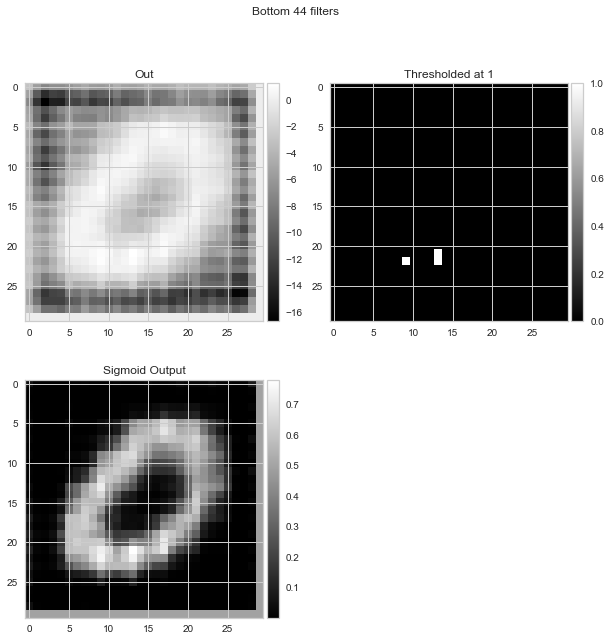

In [110]:
deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    if i  in insignificant_filters:
        continue
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights_dc3[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
out = deconvolved + de_conv_bias_dc3
plot_output(out,1,"Top "+str(num_significant_filters)+" filters")


deconvolved = np.zeros([stride * h + 2 * padding, stride * w + 2 * padding])
delta_by_filter = np.zeros(num_filters)
feature_maps = []
for i in range(num_filters):
    if i  in significant_filters:
        continue
    feature_map = deconv(features_de[0][:,:,i], de_conv_weights_dc4[:, :, 0, i], 2)
    deconvolved += feature_map
    feature_maps.append(feature_map)
plot_output(out,1,"Bottom "+str(num_filters - num_significant_filters)+" filters")

(array([ 1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.,  1.,  0.,  2.,  3.,  5.,  2.,  2.,  5.,  8.,
         4.,  3.,  6.,  2.,  2.,  5.,  3.,  4.,  4.,  4.,  4.,  7.,  6.,
         9.,  8.,  8.,  7.,  7., 16.,  9.,  7.,  5., 10., 10.,  8.,  8.,
         9., 13., 11., 12.,  7.,  5., 10.,  8., 11.,  9., 14.,  8., 17.,
        14., 15.,  9., 10., 14., 16., 13.,  7., 14., 15., 16., 11., 11.,
         6., 16., 17., 13., 12., 13., 10., 16., 11., 12., 13., 18., 13.,
        26., 86., 23., 36., 34., 17.,  4.,  4.,  1.]),
 array([-1.67044366e+01, -1.65247476e+01, -1.63450586e+01, -1.61653695e+01,
        -1.59856805e+01, -1.58059915e+01, -1.56263025e+01, -1.54466134e+01,
        -1.52669244e+01, -1.50872354e+01, -1.49075464e+01, -1.47278573e+01,
        -1.45481683e+01, -1.43684793e+01, -1.41887902e+01, -1.40091012e+01,
        -1.38294122e+01, -1.36497232e+01, -1.34700341e+01, -1.32903451e+01,
        -1.31106561e+01, -1.29309671e+01, -1.27512780e

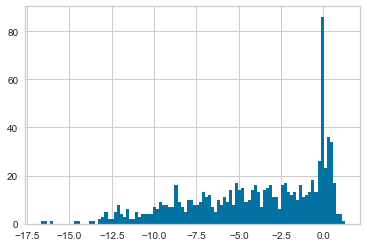

In [111]:
plt.hist(np.ravel(out),bins=100)

In [112]:
# fg_indices = np.where(out > 0)
# for x, y in zip(fg_indices[0], fg_indices[1]):
#     print(out[x,y])

0.013808298538890373
0.00038177282208257113
0.27231041739512024
0.7063900305817179
0.4337476750426932
0.05038148618122491
0.1806162443459431
0.23161737691234524
0.44176313327274386
0.8455923553565987
0.5424386944308034
0.12718434720045746
0.19959794078750492
0.2801972542137384
0.4284505657024645
0.40295113984293573
0.33545067174241217
0.252102752662821
0.4880331673187728
0.4121324274138195
0.3364858818118891
0.3795728594940909
0.6003600825566162
0.028759291133205717
0.0028152518073360708
0.5709664748125924
0.355431756349478
0.05868174091790199
0.007995736518326954
0.03812757478629904
0.3656898414587381
0.45193433636656255
0.3388838906206749
0.6178688864280518
0.7070604744343496
0.19067461180877954
0.05368776812821238
0.26101304617577264
0.07029999818495965
0.021123031309150747
0.4182214682972544
0.5680782945657157
0.4859023547750193
0.19468240541563533
0.2721312941922611
0.3863331626653563
0.5042050636733307
0.27847194606633774
0.001035951477292213
0.07398167182726975
0.700930699402717

In [113]:
a = np.asarray([[1,4,5,10],[2,1,5,23],[1,2,20,14]])
print(a)
print(np.where(a != 1 ))

[[ 1  4  5 10]
 [ 2  1  5 23]
 [ 1  2 20 14]]
(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([1, 2, 3, 0, 2, 3, 1, 2, 3]))


In [115]:
deconvolved + de_conv_bias_dc3

array([[-1.51644046e+00, -5.15667449e+00, -6.36254825e+00,
        -4.82752532e+00, -4.37617716e+00, -3.18053998e+00,
        -2.85672777e+00, -3.94763044e+00, -4.13829649e+00,
        -4.25760711e+00, -4.09301672e+00, -3.57602781e+00,
        -3.74405547e+00, -3.77903566e+00, -3.60035537e+00,
        -3.52169514e+00, -3.55835788e+00, -3.55851377e+00,
        -3.37920716e+00, -2.78514371e+00, -2.48446387e+00,
        -2.34044653e+00, -2.63749224e+00, -2.98914124e+00,
        -2.77599604e+00, -2.96942988e+00, -3.45840353e+00,
        -4.07663102e+00, -3.25565877e+00, -1.58795342e-02],
       [-5.97773592e+00, -1.54311326e+01, -1.66205955e+01,
        -1.38081407e+01, -1.16253897e+01, -9.10811854e+00,
        -8.00729401e+00, -1.08842023e+01, -1.07468732e+01,
        -1.12619337e+01, -1.03634879e+01, -1.00727793e+01,
        -9.88198753e+00, -1.00881269e+01, -9.21031966e+00,
        -9.54408276e+00, -9.23149858e+00, -9.23178290e+00,
        -8.22541633e+00, -7.32882375e+00, -6.74450952e+

In [116]:
h = features_de[0][:,:,i].shape[0]
w = features_de[0][:,:,i].shape[1]
stride = 2

In [119]:
de_conv_bias_dc3

array([-0.01587953], dtype=float32)

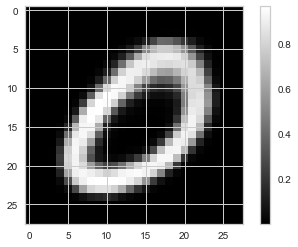

In [120]:
plt.imshow(np.squeeze(reconstructed_images[0][0]), cmap="gray")
plt.colorbar()

In [122]:
def deconv2d(w, biases, input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, name="deconv2d", stddev=0.02, with_w=False):
    print("outputshape", output_shape)
    print("stride",[1, d_h, d_w, 1])
    deconv = tf.nn.conv2d_transpose(input_,
                                    w,
                                    output_shape=output_shape,
                                    strides=[1, d_h, d_w, 1],
                                    padding="SAME"
                                   )
    deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
    return deconv

In [125]:
#deconv1_de = features_de
deconv1_de=val_decoder_features["deconv_1"][d][0]

In [127]:
out = deconv2d(de_conv_weights_dc3, de_conv_bias_dc3, deconv1_de, [64, 7, 7, 1], 3, 3, 2, 2, name='de_dc3')

outputshape [64, 7, 7, 1]
stride [1, 2, 2, 1]


In [128]:
deconv1_de.shape

(64, 14, 14, 64)

In [ ]:
de_conv_weights_dc3.shape

In [129]:
de_conv_bias_dc3.shape

(1,)

In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    de_conv_weights_tensor = tf.placeholder(tf.float32,[3, 3, 1, 64],name="weights")
    deconv1_de_tensor = tf.placeholder(tf.float32,[64,14, 14, 64], name="input")
    de_conv_bias_tensor = tf.placeholder(tf.float32,[1,],name="bias")
    out = tf.nn.sigmoid(deconv2d(de_conv_weights_tensor,
                                 de_conv_bias_tensor,
                                 deconv1_de_tensor,
                                 [64, 28, 28, 1],
                                 3, 3, 2, 2, name='de_dc4'
                                )
                       )
    reconstructed = sess.run(out,feed_dict={de_conv_weights_tensor:de_conv_weights,
                                            de_conv_bias_tensor:de_conv_bias,
                                            deconv1_de_tensor:deconv1_de
                                           })

In [ ]:
deconv1_de.shape

In [ ]:
plt.imshow(np.squeeze(reconstructed[0,:,:,:]),cmap="gray")

In [ ]:
print([k for k  in decoder_params.keys()])

In [ ]:
decoder_fc1_weights = decoder_params['decoder/de_fc1/Matrix:0']
decoder_fc1_bias = decoder_params['decoder/de_fc1/bias:0']

In [ ]:
np.matmul(latent_vectors[0][0],decoder_fc1_weights) + decoder_fc1_bias

In [ ]:
decoder_features["dense_1"][0][0][0]

In [ ]:
decoder_fc1_bias

In [ ]:
import os
import pandas as pd
import numpy as np
# from numpy.linalg import norm

# import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf

from clearn.utils.data_loader import load_images
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
from clearn.analysis.encode_decode import decode, encode, encode_and_get_features, decode_and_get_features,decode_layer1

from matplotlib import pyplot  as  plt
%matplotlib inline

N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 3

ROOT_PATH = "/home/sunilv/concept_learning_data/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=None)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


exp_config.TRAINED_MODELS_PATH


In [ ]:
z = np.zeros([64,10])

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=BATCH_SIZE,
                                z_dim=Z_DIM,
                                dataset_name=DATASET_NAME,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        dense1_de = decode_layer1(model,z,64)
        #recon_images,dense1_de, dense2_de, reshaped_de, deconv1_de = decode_and_get_features(model, z, exp_config.BATCH_SIZE)
tf.reset_default_graph()
N_3 = 32
N_2 = 128
N_1 = 64
Z_DIM = 10
run_id = 3

ROOT_PATH = "/home/sunilv/concept_learning_data/"
exp_config = ExperimentConfig(ROOT_PATH,
                              4,
                              Z_DIM,
                              [N_1, N_2, N_3],
                              num_val_samples=128,
                              confidence_decay_factor=5,
                              num_cluster_config=None)

exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [ ]:
digit = 9
dense_1_feat_9 = np.mean(decoder_features["dense_1"][digit][0][0:13],axis=0)
dense_1_feat_9.shape

digit = 0
dense_1_feat_1 = np.mean(decoder_features["dense_1"][digit][0][0:13],axis=0)
dense_1_feat_1.shape
plt.plot(dense_1_feat_1)
plt.plot(dense_1_feat_9)


In [ ]:
digit = 9
dense_1_feat_9 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=2)
print(dense_1_feat_9.shape)

digit = 0
dense_1_feat_1 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=2)
print(dense_1_feat_1.shape)
# plt.imhsow(dense_1_feat_1)
# plt.plot(dense_1_feat_9)


In [ ]:
digit = 9
dense_1_feat_9 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=0)
print(dense_1_feat_9.shape)
plt.imshow(dense_1_feat_9[:,:,2], cmap="gray")

In [ ]:
digit = 0
dense_1_feat_0 = np.mean(decoder_features["deconv_1"][digit][0][0:13],axis=0)
print(dense_1_feat_0.shape)
plt.imshow(dense_1_feat_0[:,:,2], cmap="gray")

In [ ]:
digit = 0
dense_1_feat_0 = np.mean(reconstructed_images[digit][0][0:13],axis=0)
print(dense_1_feat_0.shape)
plt.imshow(dense_1_feat_0[:,:,2], cmap="gray")

In [ ]:
de_conv_weights = decoder_params["decoder/de_dc4/w:0"]
de_conv_bias = decoder_params["decoder/de_dc4/biases:0"]